# Project: Don't Call Me Turkey

## Phase 2: PyTorch/TensorFlow, MLP

**Bài toán:** Dự đoán tiếng động trong các clip có phải là tiếng gà tây?

### Khai báo các thư viện cần thiết.
Xây dựng mô hình MLP ở cả hai framework PyTorch và TensorFlow để so sánh trong bài toán này.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Tải dữ liệu.

In [2]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

xtrain = train['audio_embedding'].tolist()
ytrain = train['is_turkey'].values
xtest = test['audio_embedding'].tolist()

## Phân tích Dữ liệu Khám phá (EDA).

### Tiền Xử Lý Dữ Liệu
Sử dụng lại các bước tiền xử lý ở phase 1.

In [3]:
x_train = pad_sequences(xtrain, maxlen=10)
x_test = pad_sequences(xtest, maxlen=10)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(ytrain)

print(f"Kích thước x_train sau padding: {x_train.shape}")
print(f"Kích thước x_test sau padding: {x_test.shape}")

def augment_features(x):
    x_flat = x.reshape((x.shape[0], -1))
    x_mean = np.mean(x, axis=1)
    x_std = np.std(x, axis=1)
    return np.hstack([x_flat, x_mean, x_std])

x_train_aug = augment_features(x_train)
x_test_aug = augment_features(x_test)

print(f"Kích thước x_train sau nâng chiều: {x_train_aug.shape}")
print(f"Kích thước x_test sau nâng chiều: {x_test_aug.shape}")

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_aug)
x_test_scaled = scaler.transform(x_test_aug)

print(f"Kích thước x_train sau chuẩn hóa: {x_train_scaled.shape}")

Kích thước x_train sau padding: (1195, 10, 128)
Kích thước x_test sau padding: (1196, 10, 128)
Kích thước x_train sau nâng chiều: (1195, 1536)
Kích thước x_test sau nâng chiều: (1196, 1536)
Kích thước x_train sau chuẩn hóa: (1195, 1536)


## Phát triển Mô hình (Model Development) và Đánh giá Mô hình (Model Evaluation).

### Thiết kế Kiến trúc (cho cả PyTorch và Keras):

- Kiến trúc MLP bao gồm nhiều lớp Dense (hoặc Linear trong PyTorch) với số lượng nơ-ron giảm dần, xen kẽ với các lớp BatchNormalization, ReLU và Dropout. Lớp đầu ra sử dụng Sigmoid.

- Các lớp Dense (Linear): Chịu trách nhiệm học các biểu diễn phi tuyến tính từ dữ liệu đầu vào. Số lượng nơ-ron giảm dần qua các lớp (512 -> 256 -> 128 -> 64 -> 32) giúp mô hình học các đặc trưng ngày càng trừu tượng và nén thông tin.

- BatchNormalization: Giúp chuẩn hóa đầu ra của lớp trước đó bằng cách trừ đi giá trị trung bình và chia cho độ lệch chuẩn. Giúp ổn định quá trình huấn luyện.
- ReLU (Rectified Linear Unit): Hàm kích hoạt phi tuyến tính. Đơn giản, hiệu quả và đẩy nhanh tốc độ hội tụ.
- Dropout (tỷ lệ 0.5): Một kỹ thuật điều hòa (regularization). Giúp ngăn chặn overfitting bằng cách ngẫu nhiên "tắt" một phần các nơ-ron trong quá trình huấn luyện, buộc mạng phải học các biểu diễn mạnh mẽ hơn và ít phụ thuộc vào bất kỳ nơ-ron cụ thể nào.
### Thiết lập Huấn luyện (cho cả PyTorch và Keras):

- Optimizer: Adam optimizer được chọn.
- Learning Rate (1e-3) và Weight Decay (1e-4)
- Weight Decay (L2 regularization): Giúp ngăn chặn overfitting bằng cách thêm một hình phạt vào hàm lỗi dựa trên độ lớn của các trọng số.
- Loss Function: Binary Cross-Entropy (BCELoss) được sử dụng.
- Scheduler (ReduceLROnPlateau): Giảm learning rate khi một metric (ở đây là AUC trên tập validation) ngừng cải thiện.
- Early Stopping: Dừng huấn luyện sớm nếu hiệu suất trên tập validation không cải thiện sau một số epoch nhất định (patience=3).


### PyTorch MLP Model

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim=1536):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Keras/TensorFlow MLP Model

In [5]:
def build_model(input_dim=1536):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512),
        BatchNormalization(),
        ReLU(),
        Dropout(0.5),

        Dense(256),
        BatchNormalization(),
        ReLU(),
        Dropout(0.5),

        Dense(128),
        BatchNormalization(),
        ReLU(),
        Dropout(0.5),

        Dense(64),
        BatchNormalization(),
        ReLU(),

        Dense(32),
        ReLU(),

        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])

    return model
model_2 = build_model()
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 965,377 (3.68 MB)

 Trainable params: 963,457 (3.68 MB)

 Non-trainable params: 1,920 (7.50 KB)

#### Sử dụng 10-Fold Stratified Cross Validation để đánh giá hiệu suất của mô hình một cách toàn diện. Các metric bao gồm AUC-ROC, Accuracy, Precision, Recall, và F1-Score.

### PyTorch Cross-Validation



1. Thiết lập ban đầu:
- Sử dụng `torch.device` để xác định có dùng GPU.
- Dữ liệu đầu vào `x_train_scaled` và `y_train` được chuyển sang `Tensor`.
- Áp dụng `StratifiedKFold(n_splits=10)` để chia dữ liệu giữ nguyên phân phối nhãn.

2. Quy trình mỗi Fold:
- **Khởi tạo mô hình `MLP(input_dim=1536)`**, hàm mất mát `BCELoss` (Binary Cross Entropy) và optimizer Adam.
-  **Chia dữ liệu train/val theo chỉ số từng fold**.
- Tạo DataLoader để mini-batch huấn luyện:
   - TensorDataset(x, y): Gộp dữ liệu đặc trưng (x) và nhãn (y) thành một tập dữ liệu PyTorch. Mỗi mẫu sẽ có dạng (x_i, y_i).
   - train_loader: Tạo DataLoader cho dữ liệu huấn luyện. Batch_size=256: Chia thành các mini-batch 256 mẫu. SShuffle=True: Xáo trộn dữ liệu trước mỗi epoch để tránh mô hình học theo thứ tự.
   - val_loader: Tạo DataLoader cho dữ liệu kiểm tra/validation. Batch_size=512: Dùng batch lớn hơn vì không cần cập nhật trọng số. Shuffle=False: Không xáo trộn để đảm bảo đánh giá ổn định.
- Huấn luyện mô hình với tối đa 30 epoch, áp dụng **early stopping sau 3 epoch không cải thiện AUC**, và sử dụng `ReduceLROnPlateau` để giảm learning rate nếu cần.
- **Sau mỗi epoch**, tính:
   - Loss
   - Accuracy trên tập train
   - AUC trên tập validation
   - Cập nhật mô hình tốt nhất (theo AUC cao nhất)
- **Sau khi huấn luyện**, đánh giá mô hình tốt nhất trên tập validation:
   - Accuracy, Precision, Recall, F1-score, AUC
   - Classification report & Confusion matrix

- Thống kê sau huấn luyện:
- In ra từng fold:
  - Accuracy (train & val)
  - Precision, Recall, F1
  - AUC
  - Thời gian huấn luyện mỗi fold
- Tính trung bình các chỉ số qua 10 fold
- Tổng thời gian huấn luyện



===== Fold 1 =====
Epoch 1 - Val AUC: 0.99511 - Train Acc: 0.41116
Epoch 2 - Val AUC: 0.99138 - Train Acc: 0.84651
Epoch 3 - Val AUC: 0.98994 - Train Acc: 0.92837
Epoch 4 - Val AUC: 0.98994 - Train Acc: 0.94326
Early stopping triggered.
Validation Accuracy: 0.92500
              precision    recall  f1-score   support

         0.0     0.9697    0.9014    0.9343        71
         1.0     0.8704    0.9592    0.9126        49

    accuracy                         0.9250       120
   macro avg     0.9200    0.9303    0.9235       120
weighted avg     0.9291    0.9250    0.9255       120



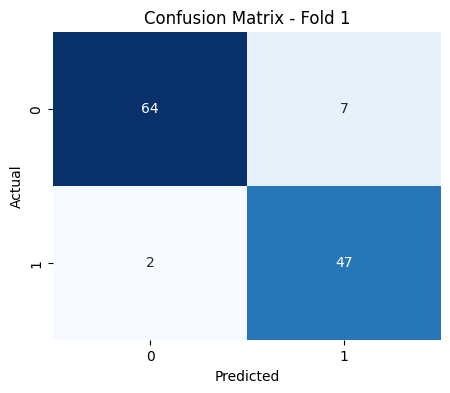


===== Fold 2 =====
Epoch 1 - Val AUC: 0.97844 - Train Acc: 0.73767
Epoch 2 - Val AUC: 0.98017 - Train Acc: 0.93953
Epoch 3 - Val AUC: 0.97873 - Train Acc: 0.95070
Epoch 4 - Val AUC: 0.97787 - Train Acc: 0.96558
Epoch 5 - Val AUC: 0.98390 - Train Acc: 0.97395
Epoch 6 - Val AUC: 0.98390 - Train Acc: 0.97953
Epoch 7 - Val AUC: 0.97643 - Train Acc: 0.98791
Epoch 8 - Val AUC: 0.97356 - Train Acc: 0.99442
Early stopping triggered.
Validation Accuracy: 0.93333
              precision    recall  f1-score   support

         0.0     0.9200    0.9718    0.9452        71
         1.0     0.9556    0.8776    0.9149        49

    accuracy                         0.9333       120
   macro avg     0.9378    0.9247    0.9300       120
weighted avg     0.9345    0.9333    0.9328       120



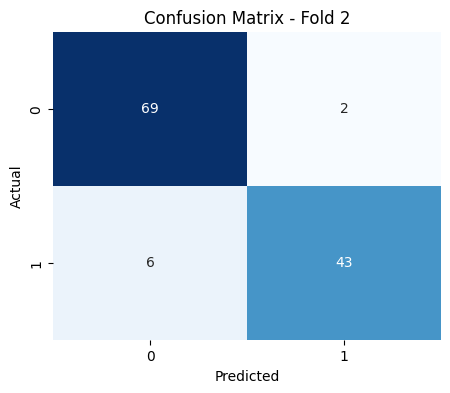


===== Fold 3 =====
Epoch 1 - Val AUC: 0.98936 - Train Acc: 0.88558
Epoch 2 - Val AUC: 0.98735 - Train Acc: 0.93953
Epoch 3 - Val AUC: 0.98505 - Train Acc: 0.95163
Epoch 4 - Val AUC: 0.98678 - Train Acc: 0.95814
Early stopping triggered.
Validation Accuracy: 0.94167
              precision    recall  f1-score   support

         0.0     0.9706    0.9296    0.9496        71
         1.0     0.9038    0.9592    0.9307        49

    accuracy                         0.9417       120
   macro avg     0.9372    0.9444    0.9402       120
weighted avg     0.9433    0.9417    0.9419       120



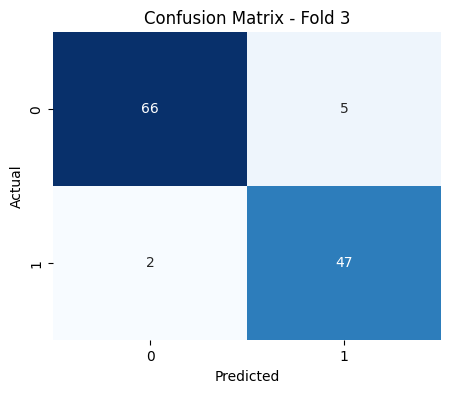


===== Fold 4 =====
Epoch 1 - Val AUC: 0.98822 - Train Acc: 0.93674
Epoch 2 - Val AUC: 0.99023 - Train Acc: 0.93860
Epoch 3 - Val AUC: 0.99281 - Train Acc: 0.95070
Epoch 4 - Val AUC: 0.99368 - Train Acc: 0.95721
Epoch 5 - Val AUC: 0.99569 - Train Acc: 0.96558
Epoch 6 - Val AUC: 0.99626 - Train Acc: 0.97674
Epoch 7 - Val AUC: 0.99655 - Train Acc: 0.98605
Epoch 8 - Val AUC: 0.99713 - Train Acc: 0.98977
Epoch 9 - Val AUC: 0.99655 - Train Acc: 0.99349
Epoch 10 - Val AUC: 0.99339 - Train Acc: 0.99721
Epoch 11 - Val AUC: 0.99138 - Train Acc: 0.99814
Early stopping triggered.
Validation Accuracy: 0.95000
              precision    recall  f1-score   support

         0.0     0.9452    0.9718    0.9583        71
         1.0     0.9574    0.9184    0.9375        49

    accuracy                         0.9500       120
   macro avg     0.9513    0.9451    0.9479       120
weighted avg     0.9502    0.9500    0.9498       120



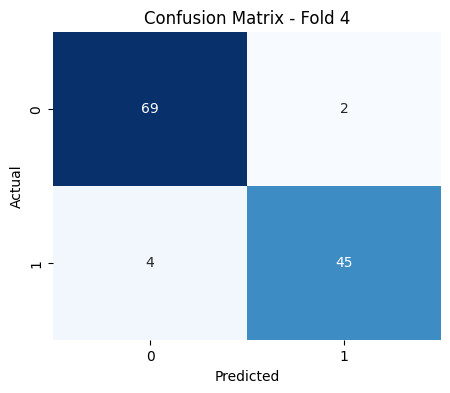


===== Fold 5 =====
Epoch 1 - Val AUC: 0.97771 - Train Acc: 0.83349
Epoch 2 - Val AUC: 0.97943 - Train Acc: 0.94233
Epoch 3 - Val AUC: 0.98257 - Train Acc: 0.94884
Epoch 4 - Val AUC: 0.98429 - Train Acc: 0.96000
Epoch 5 - Val AUC: 0.98600 - Train Acc: 0.96093
Epoch 6 - Val AUC: 0.98914 - Train Acc: 0.97488
Epoch 7 - Val AUC: 0.99343 - Train Acc: 0.98419
Epoch 8 - Val AUC: 0.99371 - Train Acc: 0.99163
Epoch 9 - Val AUC: 0.99229 - Train Acc: 0.99535
Epoch 10 - Val AUC: 0.99114 - Train Acc: 0.99814
Epoch 11 - Val AUC: 0.98914 - Train Acc: 1.00000
Early stopping triggered.
Validation Accuracy: 0.95833
              precision    recall  f1-score   support

         0.0     0.9577    0.9714    0.9645        70
         1.0     0.9592    0.9400    0.9495        50

    accuracy                         0.9583       120
   macro avg     0.9585    0.9557    0.9570       120
weighted avg     0.9583    0.9583    0.9583       120



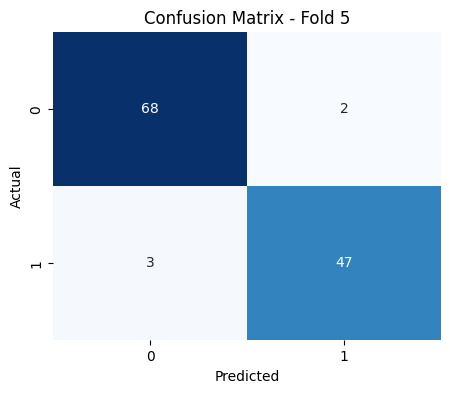


===== Fold 6 =====
Epoch 1 - Val AUC: 0.98192 - Train Acc: 0.82714
Epoch 2 - Val AUC: 0.98746 - Train Acc: 0.93587
Epoch 3 - Val AUC: 0.98921 - Train Acc: 0.95260
Epoch 4 - Val AUC: 0.98834 - Train Acc: 0.96375
Epoch 5 - Val AUC: 0.98805 - Train Acc: 0.97305
Epoch 6 - Val AUC: 0.98892 - Train Acc: 0.97862
Early stopping triggered.
Validation Accuracy: 0.93277
              precision    recall  f1-score   support

         0.0     0.9429    0.9429    0.9429        70
         1.0     0.9184    0.9184    0.9184        49

    accuracy                         0.9328       119
   macro avg     0.9306    0.9306    0.9306       119
weighted avg     0.9328    0.9328    0.9328       119



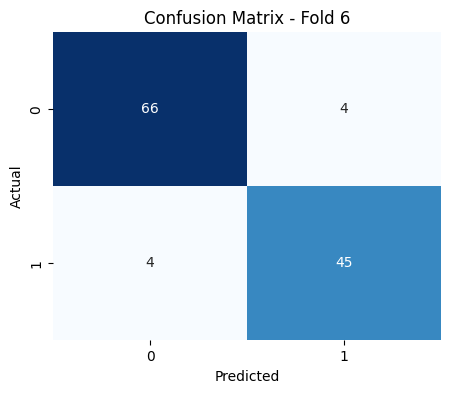


===== Fold 7 =====
Epoch 1 - Val AUC: 0.98192 - Train Acc: 0.94238
Epoch 2 - Val AUC: 0.99038 - Train Acc: 0.94610
Epoch 3 - Val AUC: 0.99038 - Train Acc: 0.95260
Epoch 4 - Val AUC: 0.98980 - Train Acc: 0.95353
Epoch 5 - Val AUC: 0.99300 - Train Acc: 0.96097
Epoch 6 - Val AUC: 0.99563 - Train Acc: 0.97491
Epoch 7 - Val AUC: 0.99388 - Train Acc: 0.98234
Epoch 8 - Val AUC: 0.99300 - Train Acc: 0.99349
Epoch 9 - Val AUC: 0.99242 - Train Acc: 0.99535
Early stopping triggered.
Validation Accuracy: 0.96639
              precision    recall  f1-score   support

         0.0     0.9714    0.9714    0.9714        70
         1.0     0.9592    0.9592    0.9592        49

    accuracy                         0.9664       119
   macro avg     0.9653    0.9653    0.9653       119
weighted avg     0.9664    0.9664    0.9664       119



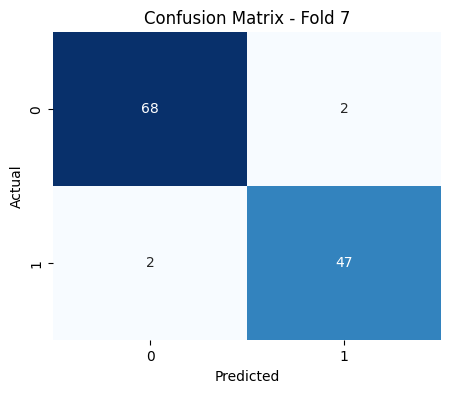


===== Fold 8 =====
Epoch 1 - Val AUC: 0.96560 - Train Acc: 0.58922
Epoch 2 - Val AUC: 0.96181 - Train Acc: 0.61803
Epoch 3 - Val AUC: 0.96472 - Train Acc: 0.93680
Epoch 4 - Val AUC: 0.96939 - Train Acc: 0.96097
Epoch 5 - Val AUC: 0.97055 - Train Acc: 0.96283
Epoch 6 - Val AUC: 0.96385 - Train Acc: 0.97398
Epoch 7 - Val AUC: 0.96822 - Train Acc: 0.98327
Epoch 8 - Val AUC: 0.96997 - Train Acc: 0.98792
Early stopping triggered.
Validation Accuracy: 0.89916
              precision    recall  f1-score   support

         0.0     0.9028    0.9286    0.9155        70
         1.0     0.8936    0.8571    0.8750        49

    accuracy                         0.8992       119
   macro avg     0.8982    0.8929    0.8952       119
weighted avg     0.8990    0.8992    0.8988       119



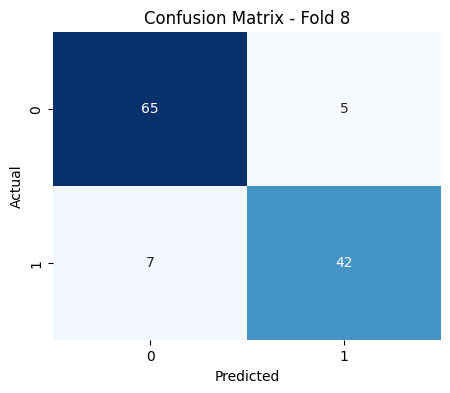


===== Fold 9 =====
Epoch 1 - Val AUC: 0.97930 - Train Acc: 0.91171
Epoch 2 - Val AUC: 0.97551 - Train Acc: 0.94052
Epoch 3 - Val AUC: 0.97493 - Train Acc: 0.94331
Epoch 4 - Val AUC: 0.97668 - Train Acc: 0.95353
Early stopping triggered.
Validation Accuracy: 0.94958
              precision    recall  f1-score   support

         0.0     0.9444    0.9714    0.9577        70
         1.0     0.9574    0.9184    0.9375        49

    accuracy                         0.9496       119
   macro avg     0.9509    0.9449    0.9476       119
weighted avg     0.9498    0.9496    0.9494       119



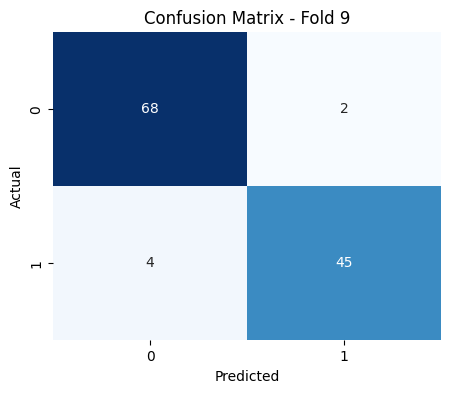


===== Fold 10 =====
Epoch 1 - Val AUC: 0.99504 - Train Acc: 0.41078
Epoch 2 - Val AUC: 0.99504 - Train Acc: 0.90799
Epoch 3 - Val AUC: 0.99650 - Train Acc: 0.94145
Epoch 4 - Val AUC: 0.99592 - Train Acc: 0.94888
Epoch 5 - Val AUC: 0.99534 - Train Acc: 0.96561
Epoch 6 - Val AUC: 0.99300 - Train Acc: 0.97677
Early stopping triggered.
Validation Accuracy: 0.95798
              precision    recall  f1-score   support

         0.0     0.9710    0.9571    0.9640        70
         1.0     0.9400    0.9592    0.9495        49

    accuracy                         0.9580       119
   macro avg     0.9555    0.9582    0.9568       119
weighted avg     0.9582    0.9580    0.9580       119



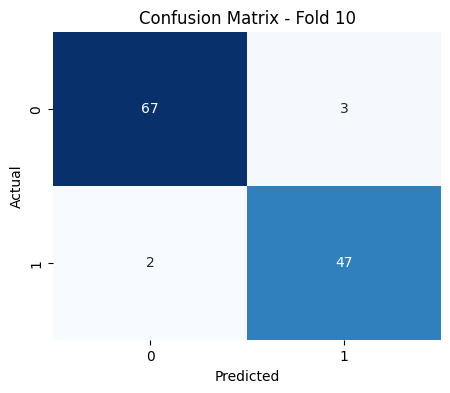

In [6]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

all_fold_metrics = []

start_total = time.time()

for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_scaled, y_train)):
    print(f"\n===== Fold {fold + 1} =====")
    fold_start = time.time()
    model_1 = MLP(input_dim=1536).to(device)
    optimizer = optim.Adam(model_1.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.BCELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    x_train_fold = x_train_tensor[train_idx]
    y_train_fold = y_train_tensor[train_idx]
    x_val_fold = x_train_tensor[val_idx]
    y_val_fold = y_train_tensor[val_idx]

    train_dataset = TensorDataset(x_train_fold, y_train_fold)
    val_dataset = TensorDataset(x_val_fold, y_val_fold)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

    best_auc = 0
    patience = 3
    patience_counter = 0
    best_train_acc = 0

    for epoch in range(30):
        model_1.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds_train = model_1(xb).squeeze()
            loss = criterion(preds_train, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        model_1.eval()
        train_preds, train_labels = [], []
        with torch.no_grad():
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model_1(xb).squeeze()
                train_preds.extend((out.cpu().numpy() > 0.5).astype(int))
                train_labels.extend(yb.cpu().numpy())

        train_acc_epoch = accuracy_score(train_labels, train_preds)

        val_preds = []
        with torch.no_grad():
            for xb, _ in val_loader:
                xb = xb.to(device)
                out = model_1(xb).squeeze()
                val_preds.extend(out.cpu().numpy())

        auc_score = roc_auc_score(y_val_fold.numpy(), val_preds)
        print(f"Epoch {epoch+1} - Val AUC: {auc_score:.5f} - Train Acc: {train_acc_epoch:.5f}")
        scheduler.step(auc_score)

        if auc_score > best_auc:
            best_auc = auc_score
            best_model_state = model_1.state_dict()
            best_train_acc = train_acc_epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model_1.load_state_dict(best_model_state)
    model_1.eval()
    val_preds_label = []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            out = model_1(xb).squeeze()
            val_preds_label.extend((out.cpu().numpy() > 0.5).astype(int))

    y_true = y_val_fold.numpy()
    y_pred = np.array(val_preds_label)

    acc_val = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    print(f"Validation Accuracy: {acc_val:.5f}")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()

    all_fold_metrics.append({
        'fold': fold + 1,
        'accuracy': acc_val,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': best_auc,
        'train_acc': best_train_acc,
        'time_sec': time.time() - fold_start
    })


### Kết quả:

In [7]:
metrics_df_Pytorch = pd.DataFrame(all_fold_metrics)
print("\n===== Tổng kết 10 Fold =====")
print(metrics_df_Pytorch)

print("\n===== Trung bình các chỉ số =====")
mean_metrics = metrics_df_Pytorch[['accuracy', 'precision', 'recall', 'f1', 'auc', 'train_acc', 'time_sec']].mean()
print(mean_metrics)

print(f"\n>>> Tổng thời gian train toàn bộ: {time.time() - start_total:.2f} giây <<<")


===== Tổng kết 10 Fold =====
   fold  accuracy  precision    recall        f1       auc  train_acc  \
0     1  0.925000   0.870370  0.959184  0.912621  0.995114   0.411163   
1     2  0.933333   0.955556  0.877551  0.914894  0.983903   0.973953   
2     3  0.941667   0.903846  0.959184  0.930693  0.989365   0.885581   
3     4  0.950000   0.957447  0.918367  0.937500  0.997126   0.989767   
4     5  0.958333   0.959184  0.940000  0.949495  0.993714   0.991628   
5     6  0.932773   0.918367  0.918367  0.918367  0.989213   0.952602   
6     7  0.966387   0.959184  0.959184  0.959184  0.995627   0.974907   
7     8  0.899160   0.893617  0.857143  0.875000  0.970554   0.962825   
8     9  0.949580   0.957447  0.918367  0.937500  0.979300   0.911710   
9    10  0.957983   0.940000  0.959184  0.949495  0.996501   0.941450   

   time_sec  
0  8.266870  
1  2.136559  
2  1.104035  
3  3.591607  
4  2.969537  
5  1.598634  
6  2.318493  
7  2.123099  
8  1.105580  
9  2.278418  

===== Trung

### Đánh giá về hiệu suất
- Accuracy trung bình ~94.2%: Đây là con số khá cao, cho thấy mô hình phân loại tốt phần lớn các mẫu. Acc trên train là: ~90%.

- Precision (93.1%) và Recall (92.6%) khá cân bằng: Điều này là rất tốt, mô hình không bị thiên lệch quá mức về một phía.

- F1-score (~93%): Thể hiện hiệu quả cân đối giữa precision và recall, mô hình khá ổn định.

- AUC trung bình rất cao (~0.99): Mô hình có khả năng phân biệt cực tốt giữa các lớp.

### Keras/TensorFlow Cross-Validation

- Thiết lập:
  - Sử dụng `StratifiedKFold(n_splits=10)` để đảm bảo tỉ lệ nhãn đều nhau giữa các fold.
  - Trong mỗi fold:
    - Dữ liệu được chia thành tập huấn luyện và tập kiểm tra (validation).
    - Mô hình được khởi tạo lại từ đầu bằng `build_model(input_dim=1536)`.

- Kỹ thuật huấn luyện:
  - **EarlyStopping**: Dừng huấn luyện nếu AUC trên tập validation không cải thiện sau 3 epoch (theo chiều "max").
  - **ReduceLROnPlateau**: Giảm learning rate khi AUC không cải thiện trong 2 epoch liên tiếp.

- Quy trình mỗi Fold:
1. Huấn luyện mô hình với tối đa 30 epoch, batch size 256.
2. Dự đoán xác suất và nhãn trên tập huấn luyện và tập validation.
3. Tính các chỉ số đánh giá trên validation:
   - Accuracy, Precision, Recall, F1-score, AUC
4. Hiển thị Classification Report và Confusion Matrix cho từng fold.
5. Ghi lại thời gian huấn luyện mỗi fold.

- Tổng kết sau huấn luyện:
  - Lưu lại các chỉ số cho mỗi fold vào `metrics_df_keras`.
  - Tính **trung bình các chỉ số** Accuracy, Precision, Recall, F1-score, AUC.
  - Tính **thời gian huấn luyện trung bình và tổng cộng** cho 10 fold.



===== Fold 1 =====

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Train Accuracy: 0.94698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Val AUC: 0.98994, Accuracy: 0.95000
              precision    recall  f1-score   support

           0     0.9577    0.9577    0.9577        71
           1     0.9388    0.9388    0.9388        49

    accuracy                         0.9500       120
   macro avg     0.9483    0.9483    0.9483       120
weighted avg     0.9500    0.9500    0.9500       120



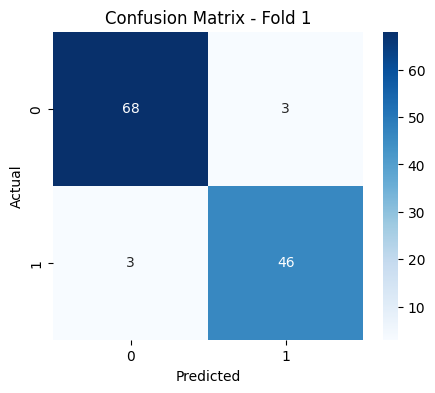

Thời gian huấn luyện Fold 1: 9.33 giây

===== Fold 2 =====

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 16.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Train Accuracy: 0.98512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Val AUC: 0.98045, Accuracy: 0.91667
              precision    recall  f1-score   support

           0     0.9420    0.9155    0.9286        71
           1     0.8824    0.9184    0.9000        49

    accuracy                         0.9167       120
   macro avg     0.9122    0.9169    0.9143       120
weighted avg     0.9177    0.9167    0.9169       120



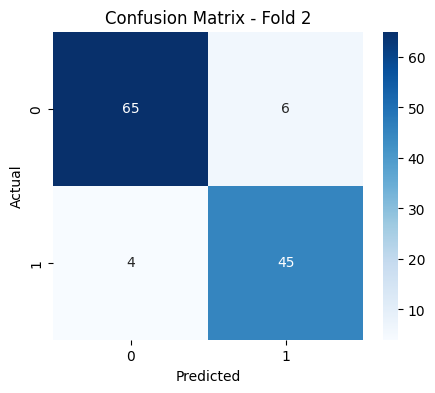

Thời gian huấn luyện Fold 2: 12.02 giây

===== Fold 3 =====

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Train Accuracy: 0.94233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Val AUC: 0.99051, Accuracy: 0.93333
              precision    recall  f1-score   support

           0     0.9846    0.9014    0.9412        71
           1     0.8727    0.9796    0.9231        49

    accuracy                         0.9333       120
   macro avg     0.9287    0.9405    0.9321       120
weighted avg     0.9389    0.9333    0.9338       120



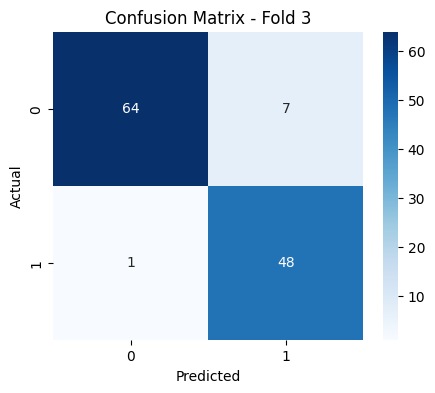

Thời gian huấn luyện Fold 3: 7.98 giây

===== Fold 4 =====

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
Train Accuracy: 0.94884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Val AUC: 0.99195, Accuracy: 0.96667
              precision    recall  f1-score   support

           0     0.9718    0.9718    0.9718        71
           1     0.9592    0.9592    0.9592        49

    accuracy                         0.9667       120
   macro avg     0.9655    0.9655    0.9655       120
weighted avg     0.9667    0.9667    0.9667       120



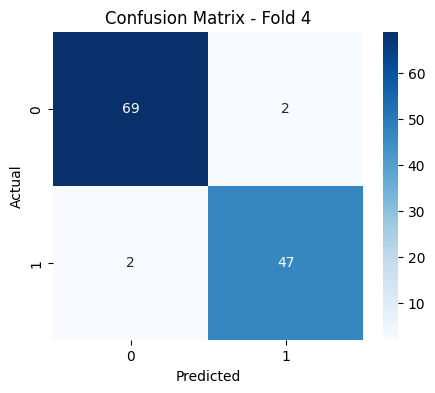

Thời gian huấn luyện Fold 4: 9.23 giây

===== Fold 5 =====

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Train Accuracy: 0.90791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Val AUC: 0.98171, Accuracy: 0.90000
              precision    recall  f1-score   support

           0     0.9833    0.8429    0.9077        70
           1     0.8167    0.9800    0.8909        50

    accuracy                         0.9000       120
   macro avg     0.9000    0.9114    0.8993       120
weighted avg     0.9139    0.9000    0.9007       120



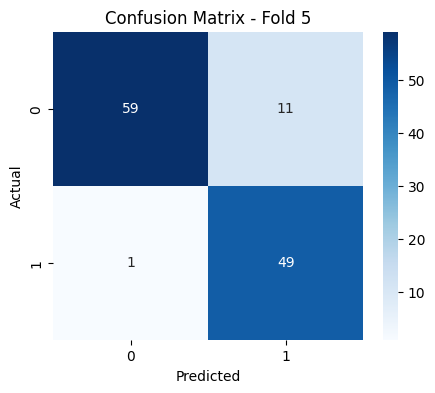

Thời gian huấn luyện Fold 5: 8.46 giây

===== Fold 6 =====

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Train Accuracy: 0.96190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Val AUC: 0.98805, Accuracy: 0.93277
              precision    recall  f1-score   support

           0     0.9697    0.9143    0.9412        70
           1     0.8868    0.9592    0.9216        49

    accuracy                         0.9328       119
   macro avg     0.9282    0.9367    0.9314       119
weighted avg     0.9356    0.9328    0.9331       119



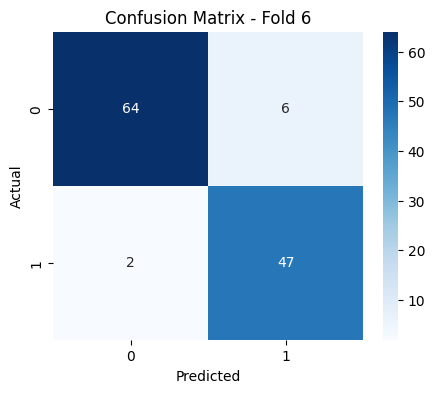

Thời gian huấn luyện Fold 6: 10.23 giây

===== Fold 7 =====

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 17.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
Train Accuracy: 0.99442
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Val AUC: 0.99650, Accuracy: 0.95798
              precision    recall  f1-score   support

           0     0.9710    0.9571    0.9640        70
           1     0.9400    0.9592    0.9495        49

    accuracy                         0.9580       119
   macro avg     0.9555    0.9582    0.9568       119
weighted avg     0.9582    0.9580    0.9580       119



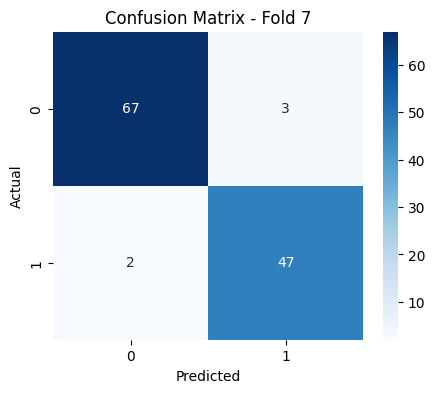

Thời gian huấn luyện Fold 7: 14.46 giây

===== Fold 8 =====

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Train Accuracy: 0.95074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Val AUC: 0.97289, Accuracy: 0.89916
              precision    recall  f1-score   support

           0     0.9028    0.9286    0.9155        70
           1     0.8936    0.8571    0.8750        49

    accuracy                         0.8992       119
   macro avg     0.8982    0.8929    0.8952       119
weighted avg     0.8990    0.8992    0.8988       119



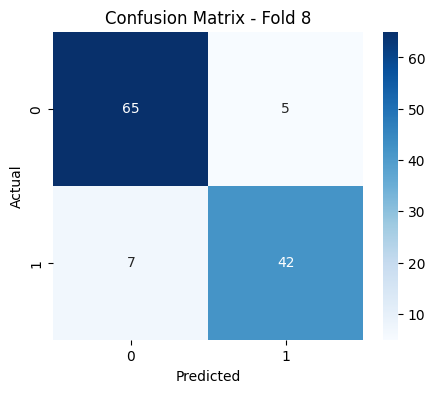

Thời gian huấn luyện Fold 8: 8.99 giây

===== Fold 9 =====

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Train Accuracy: 0.90520
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Val AUC: 0.97726, Accuracy: 0.89076
              precision    recall  f1-score   support

           0     0.9831    0.8286    0.8992        70
           1     0.8000    0.9796    0.8807        49

    accuracy                         0.8908       119
   macro avg     0.8915    0.9041    0.8900       119
weighted avg     0.9077    0.8908    0.8916       119



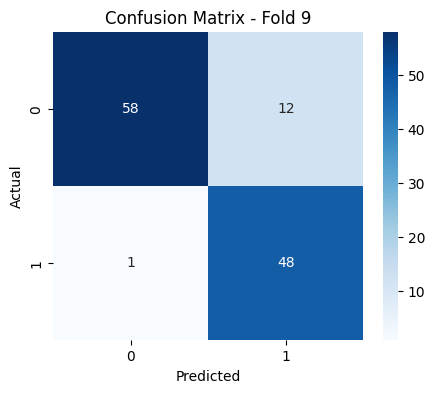

Thời gian huấn luyện Fold 9: 9.02 giây

===== Fold 10 =====

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Train Accuracy: 0.93773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Val AUC: 0.99796, Accuracy: 0.95798
              precision    recall  f1-score   support

           0     0.9710    0.9571    0.9640        70
           1     0.9400    0.9592    0.9495        49

    accuracy                         0.9580       119
   macro avg     0.9555    0.9582    0.9568       119
weighted avg     0.9582    0.9580    0.9580       119



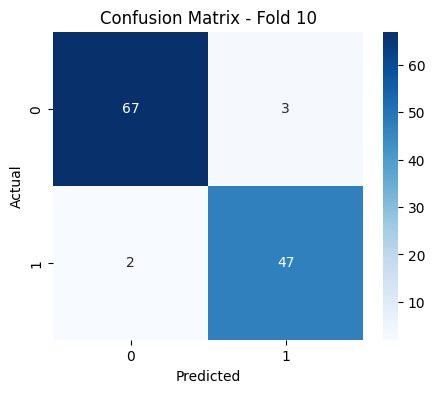

Thời gian huấn luyện Fold 10: 8.99 giây


In [8]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
all_fold_metrics = []
fold_times = []
start_all = time.time()

for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_scaled, y_train)):
    print(f"\n===== Fold {fold + 1} =====")
    start_fold = time.time()

    x_tr, x_val = x_train_scaled[train_idx], x_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model_2 = build_model(input_dim=1536)

    early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=2, mode='max', verbose=1)

    history = model_2.fit(x_tr, y_tr, validation_data=(x_val, y_val),
                        epochs=30, batch_size=256, verbose=0,
                        callbacks=[early_stop, reduce_lr])


    train_preds = model_2.predict(x_tr, batch_size=512).flatten()
    train_labels = (train_preds > 0.5).astype(int)
    acc_train = accuracy_score(y_tr, train_labels)
    print(f"Train Accuracy: {acc_train:.5f}")

    val_preds = model_2.predict(x_val, batch_size=512).flatten()
    val_labels = (val_preds > 0.5).astype(int)

    acc_val = accuracy_score(y_val, val_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, val_labels, average='binary')
    auc_val = roc_auc_score(y_val, val_preds)

    print(f"Val AUC: {auc_val:.5f}, Accuracy: {acc_val:.5f}")
    print(classification_report(y_val, val_labels, digits=4))

    cm = confusion_matrix(y_val, val_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()

    all_fold_metrics.append({
        'fold': fold + 1,
        'accuracy_train': acc_train,
        'accuracy_val': acc_val,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_val,
    })

    end_fold = time.time()
    fold_duration = end_fold - start_fold
    fold_times.append(fold_duration)
    print(f"Thời gian huấn luyện Fold {fold + 1}: {fold_duration:.2f} giây")

end_all = time.time()
total_time = end_all - start_all
avg_time = np.mean(fold_times)

### Kết quả:

In [9]:
metrics_df_Keras = pd.DataFrame(all_fold_metrics)
print("\n===== Tổng kết 10 Fold =====")
print(metrics_df_Keras)

print("\n===== Trung bình các chỉ số =====")
print(metrics_df_Keras.mean(numeric_only=True))

print(f"\n===== Thống kê thời gian huấn luyện =====")
print(f"Tổng thời gian huấn luyện 10 fold: {total_time:.2f} giây")
print(f"Thời gian trung bình mỗi fold: {avg_time:.2f} giây")


===== Tổng kết 10 Fold =====
   fold  accuracy_train  accuracy_val  precision    recall        f1       auc
0     1        0.946977      0.950000   0.938776  0.938776  0.938776  0.989940
1     2        0.985116      0.916667   0.882353  0.918367  0.900000  0.980454
2     3        0.942326      0.933333   0.872727  0.979592  0.923077  0.990515
3     4        0.948837      0.966667   0.959184  0.959184  0.959184  0.991952
4     5        0.907907      0.900000   0.816667  0.980000  0.890909  0.981714
5     6        0.961896      0.932773   0.886792  0.959184  0.921569  0.988047
6     7        0.994424      0.957983   0.940000  0.959184  0.949495  0.996501
7     8        0.950743      0.899160   0.893617  0.857143  0.875000  0.972886
8     9        0.905204      0.890756   0.800000  0.979592  0.880734  0.977259
9    10        0.937732      0.957983   0.940000  0.959184  0.949495  0.997959

===== Trung bình các chỉ số =====
fold              5.500000
accuracy_train    0.948116
accuracy_val

### Đánh giá hiệu suất
- Accuracy trên tập train trung bình ~94.8%, trên tập validation ~93%.

- Precision trung bình ~89.3%, Recall ~95%, F1-score ~92%

- Recall cao hơn precision, nghĩa là mô hình hơi thiên về bắt nhiều true positive hơn, chấp nhận một số false positive.

- F1 ~92% phản ánh sự cân bằng tốt giữa precision và recall, phù hợp nếu mục tiêu không bỏ sót các trường hợp quan trọng.

- AUC trung bình ~0.986: Cho thấy mô hình phân biệt các lớp về mặt xác suất dự đoán, gần như không bị nhầm lẫn lớn.
- Nguyên nhân có thể là do dropout là 0.5 khá lớn.

###  Tổng Kết và So Sánh Hiệu Suất
Tổng hợp kết quả trung bình từ cả hai frameworks để dễ dàng so sánh hiệu suất và hiệu quả tính toán.


### Nhận xét:
- PyTorch cho kết quả tốt hơn về Accuracy, Precision, F1-score, cho thấy mô hình cân bằng giữa độ chính xác và khả năng nhận diện đúng các lớp.

- Recall ở cả hai framework là tương đương, đều nhận diện được phần lớn mẫu dương (gà tây).

- AUC tương đương, chứng tỏ cả hai mô hình đều phân biệt tốt giữa hai lớp.

- Keras có Recall cao hơn Precision → mô hình có xu hướng dự đoán nhiều mẫu dương hơn, đôi khi quá lạc quan → dẫn đến Precision thấp.


- Tuy nhiên, có sự khác biệt rõ rệt về hiệu suất chi tiết và tốc độ:
- PyTorch nhanh gấp ~3 lần so với Keras/TensorFlow trong huấn luyện mô hình. Điều này có thể do:

  - PyTorch code nhẹ hơn, ít overhead hơn.

  - Keras thường tự động hóa nhiều bước (như tracing, graph mode) gây chậm nếu không tối ưu.

### Ưu nhược điểm từng framework
- PyTorch
  - Ưu điểm:

    - Thời gian huấn luyện nhanh hơn.
    - Hiệu suất mô hình tốt hơn với bài toán này .
- Keras/TensorFlow
  - Ưu điểm:

    - Hỗ trợ nhiều công cụ quản lý huấn luyện (early stopping, TensorBoard, model checkpoint…).

    - Thích hợp nếu làm các mô hình phức tạp

- Nhược điểm:

  - Chậm hơn trong huấn luyện nếu không tối ưu.

- Kết luận: Với mô hình MLP này, PyTorch là lựa chọn tối ưu hơn nhờ hiệu suất phân loại tốt hơn (đặc biệt là Precision) và tốc độ huấn luyện vượt trội.

### Dự Đoán Trên Tập Test và Lưu Kết Quả
Cuối cùng, chọn mô hình MLP PyTorch là mô hình tốt nhất sẽ được dùng để dự đoán kết quả trên file test.json và lưu lại mô hình này.

### Dự Đoán PyTorch

In [10]:
print("\n===== Dự đoán trên tập test =====")
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).to(device)

model_1.eval()
with torch.no_grad():
    test_preds = model_1(x_test_tensor).squeeze().cpu().numpy()

final_model_path = 'final_best_model.pth'
torch.save(model_1.state_dict(), final_model_path)
print(f"Đã lưu mô hình tốt nhất cuối cùng vào: {final_model_path}")

df_preds = pd.DataFrame({
    'vid_id': test['vid_id'].values,
    'is_turkey': test_preds
})
df_preds.to_csv('submission.csv', index=False)
print("File dự đoán đã lưu: submission.csv")


===== Dự đoán trên tập test =====
Đã lưu mô hình tốt nhất cuối cùng vào: final_best_model.pth
File dự đoán đã lưu: submission.csv


## Tài liệu tham khảo
- [Tham khảo về Multi-layer Perceptron.](https://www.facebook.com/aivietnam.edu.vn/posts/ad-g%E1%BB%ADi-c%C3%A1c-b%E1%BA%A1n-b%C3%A0i-t%E1%BA%ADp-v%E1%BB%81-multi-layer-perceptron-mlp-l%C3%A0-%C4%91%C6%B0%E1%BB%A3c-xem-l%C3%A0-m%C3%B4-h%C3%ACnh-h%E1%BB%8Dc-/901308902111829/)
- [Cách xây dựng MLP bằng thư viện Pytorch](https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
- [Multi-layer Perceptron và Backpropagation](https://machinelearningcoban.com/2017/02/24/mlp/)
- [Giới thiệu về Keras](https://machinelearningcoban.com/2018/07/06/deeplearning/)
- [Xây dựng MLP bằng thư viện Keras/TensorFlow](https://vitalflux.com/keras-multilayer-perceptron-mlp-example/)
- [Batch Normalization and Dropout](https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization?)
- [Thứ tự Batch Normalization vs. Dropout](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout?)

